## Informed Digital Normalization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
import numpy as np
import scipy as sp
from scipy import stats

In [53]:
import pandas as pd

In [39]:
import seaborn as sns

In [42]:
sns.set_style('ticks')
figsize(12,8)

### Playing Around with Poisson

In [27]:
from collections import deque

class MovingStat(object):
    
    def __init__(self, period):
        assert type(period) is int and period > 0
        self.period = period
        self.stream = deque()
        
    def push(self, item):
        self.stream.append(item)
        if len(self.stream) > self.period:
            self.stream.popleft()
    
    def measure(self, func):
        if len(self.stream) == 0:
            return 0.0
        else:
            return func(self.stream)

In [46]:
N = np.random.poisson(10, 10000)
mstat = MovingStat(10)
Nmean = []
for i, n in enumerate(N):
    mstat.push(n)
    if i % 100 == 0:
        Nmean.append(mstat.measure(np.mean))

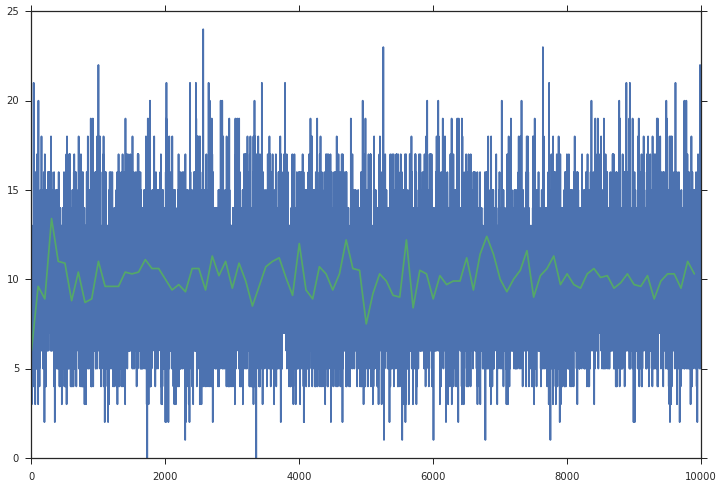

In [47]:
plot(N)
plot(arange(0, 10000, 100), Nmean)

(array([  28.,  102.,  218.,  249.,  118.,  161.,   91.,   23.,    8.,    2.]),
 array([  3. ,   4.8,   6.6,   8.4,  10.2,  12. ,  13.8,  15.6,  17.4,
         19.2,  21. ]),
 <a list of 10 Patch objects>)

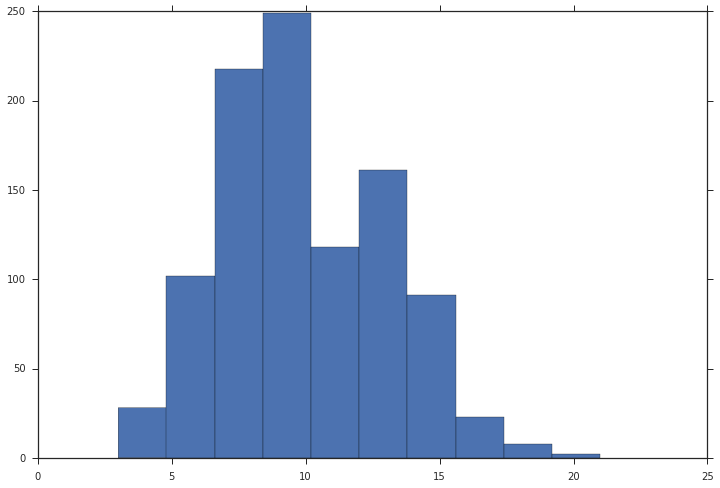

In [45]:
hist(np.random.poisson(10, 1000))

### Ecoli Test Data

from http://cb2.igs.umaryland.edu/clovr/Public_Benchmarks/CloVR-Microbe/EcoliIllumina/EcoliIlluminaPairedEnd.tar.gz

In [175]:
ecoli_df = pd.read_csv('ecoli.pe.qc.fq.stats.csv')

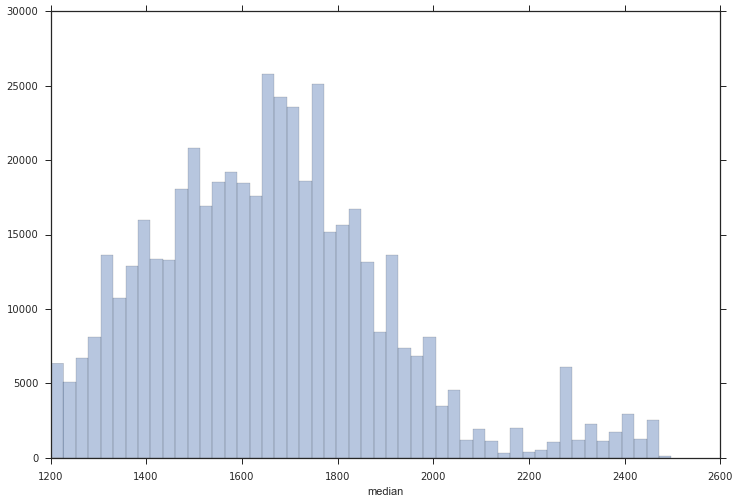

In [176]:
sns.distplot(ecoli_df.query('median > 1200 & median < 2500')['median'], kde=False)

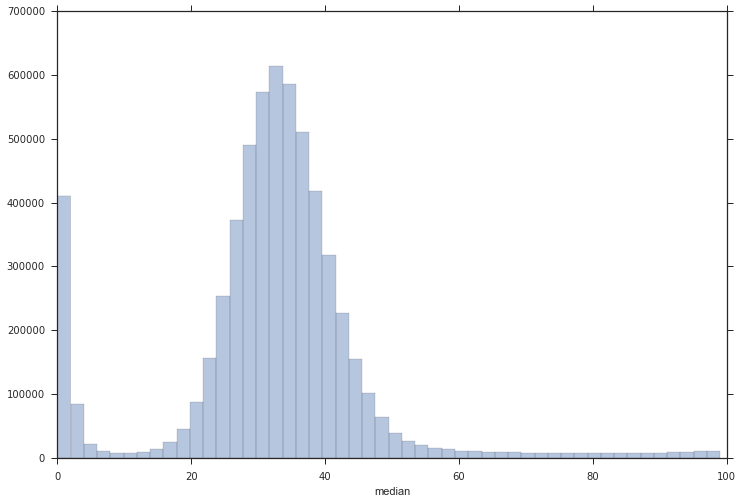

In [208]:
sns.distplot(ecoli_df.query('median < 100')['median'], kde=False)

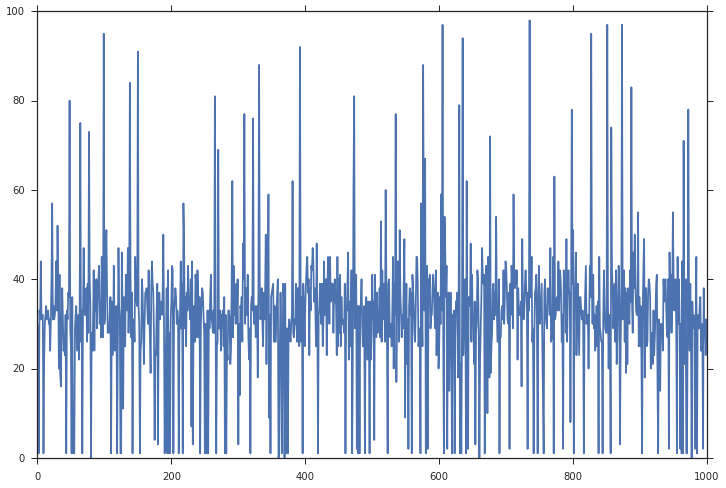

In [178]:
plot(ecoli_df.query('median < 100').sample(1000)['median'])

In [179]:
ecoli_sub = ecoli_df.sample(10000)['median']

In [105]:
res = [r for r in track_ps(ecoli_sub)]

In [220]:
from scipy.optimize import minimize
from scipy.misc import factorial

def quick_fit(data, start, stop):

    def negLogLikelihood(params, data):
        """ the negative log-Likelohood-Function"""
        ps = stats.poisson(params[0])

        lnl = - np.sum(np.log(ps.pmf(data)))
        return lnl

    result = minimize(negLogLikelihood,  # function to minimize
                      x0=np.ones(1),     # start value
                      args=(data,),      # additional arguments for function
                      method='Powell',   # minimization method, see docs
                      )
    print result
    
    # Plot coverage histogram
    sns.distplot(data, kde=False, norm_hist=True, bins=50)
    
    X = np.arange(start, stop)

    plot(X, stats.poisson.pmf(X, data.median()), '-', lw=2, 
         label=r'$\mu = {}$ (median)'.format(data.median()))

    plot(X, stats.poisson.pmf(X, result.x), '--', lw=2,
        label='r$\mu = {:.2f}$ (fitted)'.format(float(result.x)))
    
    axis(xmin=start, xmax=stop)
    
    legend()

  status: 0
 success: True
   direc: array([[ 0.13335577]])
    nfev: 43
     fun: 37419837.224581636
       x: array(31.97638946893253)
 message: 'Optimization terminated successfully.'
     nit: 2


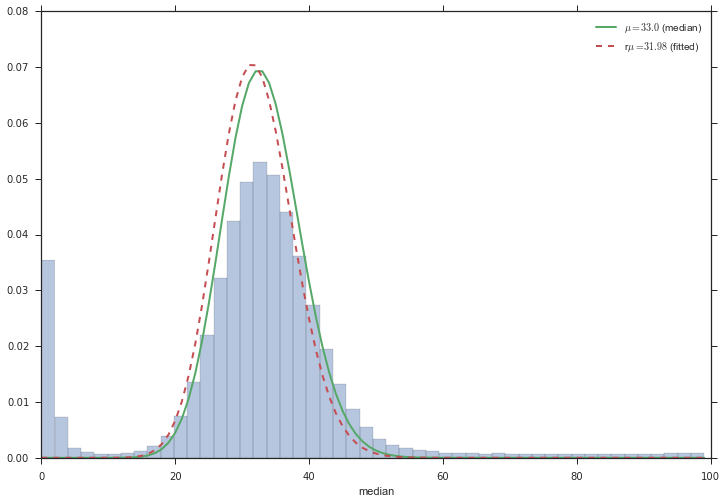

In [224]:
quick_fit(ecoli_df.query('median < 100')['median'], 0, 100)

  status: 1
 success: False
   direc: array([[ 1.]])
    nfev: 1001
     fun: inf
       x: array(200.27053003903018)
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 77


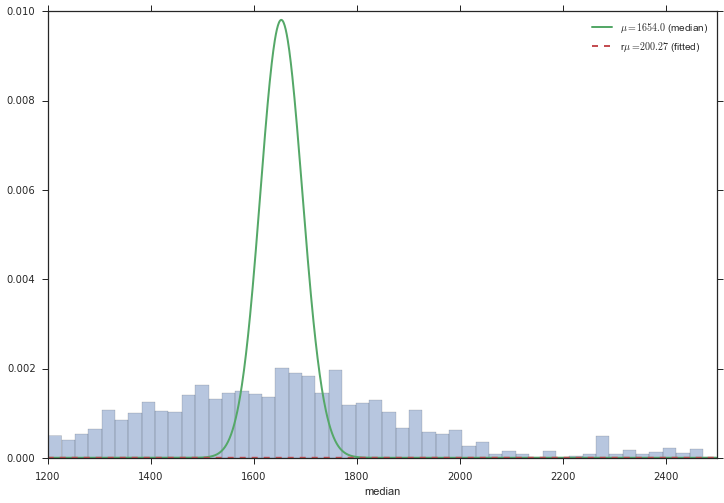

In [222]:
quick_fit(ecoli_df.query('median > 1200 & median < 2500')['median'], 1200, 2500)

### New Normalization Function

In [231]:
import khmer
import screed

In [329]:
def normalize_by_p(read_gen, C, out_fp):
    ps = stats.poisson(C)
    r = np.random.rand
    probs = [1 - ps.cdf(x) for x in xrange(5000)]
    
    ct = khmer.Countgraph(25, 1e8, 4)
    
    n = 0
    n_kept = 0
    for i, record in enumerate(read_gen):
        if i % 500000 == 0:
            msg = 'Processed {} reads...'.format(i)
            print msg
        n += 1
        
        seq = record.sequence
        
        ct.consume(seq)
        med, _, _ = ct.get_median_count(seq)
        try:
            p = probs[med]
        except IndexError:
            # For the stupidly high abundance, just toss
            continue
        
        if r() < p:
            out_fp.write('>{name}\n{seq}\n'.format(name=record.name, seq=seq))
            n_kept += 1
    print 'Processed', n, ', kept', n_kept

In [322]:
from khmer.utils import write_record, broken_paired_reader

def normalize_by_p_v2(read_fn, C, out_fp, K=25, M=1e8):
    ps = stats.poisson(C)
    r = np.random.rand
    probs = [1 - ps.cdf(x) for x in xrange(5000)]
    
    ct = khmer.Countgraph(K, M, 4)
    
    n = 0
    n_kept = 0
    for i, is_paired, read0, read1 in broken_paired_reader(screed.open(read_fn), min_length=K):
        if i % 500000 == 0:
            msg = 'Processed {} reads, kept {}...'.format(i, n_kept)
            print msg

        if is_paired:
            n += 2
        else:
            n += 1
        
        passed_filter = False
        batch = []
        batch.append(read0)
        if read1 is not None:
            batch.append(read1)
        
        for record in batch:
            ct.consume(record.sequence)
            med, _, _ = ct.get_median_count(record.sequence)
            
            try:
                p = probs[med]
            except IndexError:
                # For the stupidly high abundance, just toss
                continue

            if r() < p:
                n_kept += 1
                passed_filter = True
        
        if passed_filter:
            for record in batch:
                if record is not None:
                    write_record(record, out_fp)

In [321]:
with open('ecoli.np10.fa', 'wb') as fp:
    normalize_by_p_v2('ecoli.pe.qc.fq', 10, fp)

Processed 0 reads...
Processed 500000 reads...
Processed 1000000 reads...
Processed 1500000 reads...
Processed 2000000 reads...
Processed 2500000 reads...
Processed 3000000 reads...
Processed 3500000 reads...
Processed 4000000 reads...
Processed 4500000 reads...
Processed 5000000 reads...
Processed 5500000 reads...
Processed 6000000 reads...
Processed 6500000 reads...
Processed 7000000 reads...
Processed 7500000 reads...


In [259]:
lam = 10.0
print lam - np.log(2), lam + (1.0 / 3.0)

9.30685281944 10.3333333333


In [311]:
c10_df = pd.read_csv('ecoli.pe.qc.fq.C10.hist')

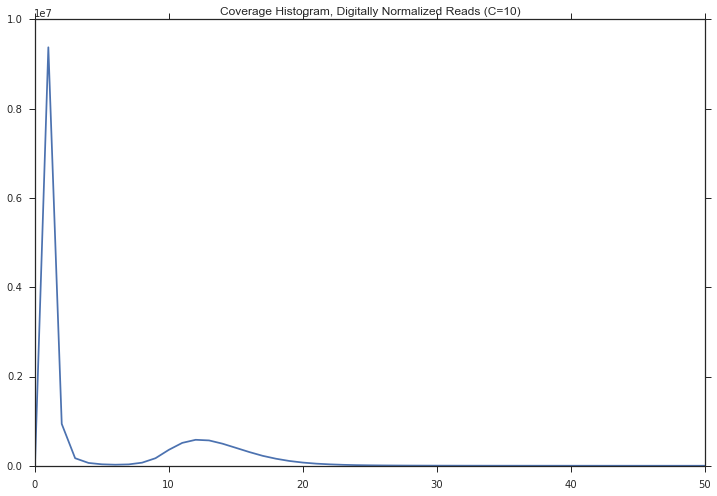

In [330]:
plot(c10_df['abundance'], c10_df['count'])
axis(xmax=50)
title('Coverage Histogram, Digitally Normalized Reads (C=10)')

In [323]:
np10_df = pd.read_csv('ecoli.np10.fa.hist')

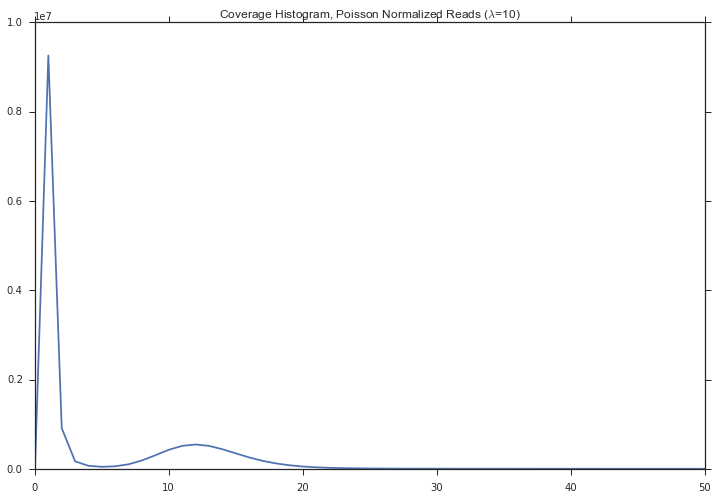

In [331]:
plot(np10_df['abundance'], np10_df['count'])
axis(xmax=50)
title('Coverage Histogram, Poisson Normalized Reads ($\lambda$=10)')